# Выявление закономерностей,  
# определяющих успешность компьютерной игры 

### Введение

Интернет-магазин продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Имеются данные до 2016 года. Сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. 

Описание данных  

•	Name — название игры  
•	Platform — платформа  
•	Year_of_Release — год выпуска  
•	Genre — жанр игры  
•	NA_sales — продажи в Северной Америке (миллионы долларов)  
•	EU_sales — продажи в Европе (миллионы долларов)  
•	JP_sales — продажи в Японии (миллионы долларов)    
•	Other_sales — продажи в других странах (миллионы долларов)  
•	Critic_Score — оценка критиков (максимум 100)  
•	User_Score — оценка пользователей (максимум 10)  
•	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.  

Краткий план работы:
1. Изучение общей информации о базе данных
2. Предобработка и подготовка данных
3. Анализ данных  
4. Составление портрета пользователя каждого региона
5. Проверка гипотез
6. Общий вывод

### 1. Изучение общей информации о базе данных

In [161]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
pd.set_option('display.max_columns', None)

In [162]:
# чтение файла базы данных
df = pd.read_csv('/datasets/games.csv')

In [163]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [165]:
# просмотрим значения 'User_Score', чтобы выяснить причину назначения типа данных 'object'
df['User_Score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.2       2
1.3       2
0.7       2
9.7       1
0         1
Name: User_Score, Length: 96, dtype: int64

In [166]:
df.duplicated().sum()

0

#### Вывод по изучению базы данных:   

-дупликаты не обнаружены;  

-потребуется заменить названия столбцов (привести к нижнему регистру);  

-потребуеся изменение типов данных:  
--год выпуска - из 'float' в 'integer',  
--оценка пользователей - из 'object' во 'float';  

-имеются пропуски:  
--название игры - пропуск заполнен быть не может, оставим как есть, доля несущественна (2/16715),  
--год выпуска - пропуск заполнен быть не может, доля несущественна (269/16715, т.е. 1.6%),  
--жанр - пропуск заполнен быть не может, оставим как есть, доля несущественна (2/16715),  
--оценка критиков - пропуск заполнен быть не может, оставим как есть, доля существенна (51%),  
--оценка пользователей - присутсвуют два вида пропусков, 'nan' и 'tbd'; скорее всего 'tbd' означает 'to be determined', т.е. на момент составления базы данных информация отсутсвовала; заменим 'tbd' на 'nan' (обозначим явный пропуск); пропуск заполнен быть не может, доля существенна (55%).  

Причиной пропусков в названии игры и годе выпуска, предположительно, является техническая либо человеческая ошибка при составлении базы данных.  
Причиной пропусков в оценке критиками и пользователями, вероятно, является отсутствие оценки на момент составления базы. Несмотря на существенную долю строк с пропущенной информацией об оценке (51-55%) замещать пропуски какими-либо средними или медианными значениями будет неправильно, т.к. велика вероятность отличия фактической (неизвестной нам) оценки от среднего либо медианного значения, вычисленного по какому-то ни было признаку.

### 2.1. Предобработка данных

In [167]:
# переведем названия столбцов в нижний регистр
df.columns=df.columns.str.lower()

In [168]:
# заменим тип данных года выпуска - 'float' на 'integer'. 
# т.к. в этом столбце есть пропуски ('nan'), то, чтобы сработал метод '.astype', заменим пропуски на ноль.
df['year_of_release']=df['year_of_release'].fillna(0).astype(int)

In [169]:
# заменим 'tbd' на 'nan' (обозначим явный пропуск) в столбце 'user_score'
df.loc[df['user_score']=='tbd','user_score']=df[df['user_score']=='tbd']['user_score'].replace('tbd', np.nan)

In [170]:
# и переведем 'user_score' в тип 'float'
df['user_score']=pd.to_numeric(df['user_score'], errors='coerce')

In [171]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


### 2.2. Посчет суммарных продаж каждой игры во всех регионах 

In [173]:
df['total_sales']=df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']

In [174]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### 3. Анализ данных

### 3.1. Выявление и сравнение потенциально прибыльных платформ

In [175]:
# посмотрим, сколько игр выпускалось в разные годы
dfy=df['year_of_release'].value_counts().reset_index()
dfy[dfy['index']!=0].sort_values('index', ascending=False)

,index,year_of_release
14,2016,502
11,2015,606
12,2014,581
13,2013,544
10,2012,653
4,2011,1136
2,2010,1255
1,2009,1426
0,2008,1427
3,2007,1197


Очевидно, что для прогнозирования на следующий год важны данные не за весь срок наблюдений (с 1980), а только за некоторый актуальный период.  
Чтобы объективно сравнивать продажи недавно появившихся платформ с продажами тех, которые существуют давно, в качестве актуального периода примем срок, равный половине времени существования платформы.  
Вычислим актуальный период.

In [176]:
# сгруппируем данные по платформам и по сумме продаж в год
df1=df.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum').reset_index()

In [177]:
df1=df1.rename(columns={0:'year_unknown'})

In [178]:
df1

year_of_release,platform,year_unknown,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,2600,10.50,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3DS,1.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
3,DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.38,5.16,5.99,1.07,0.29,NaN,NaN,NaN,NaN,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DS,3.34,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.27,130.14,119.81,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
5,GB,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,64.97,4.89,5.57,25.49,NaN,12.18,3.60,36.03,6.37,26.90,38.00,19.76,9.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GBA,4.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,61.53,74.16,56.67,77.91,33.86,5.28,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GC,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.34,51.81,50.61,28.82,27.62,11.26,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.60,4.33,12.64,3.07,8.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посчитаем, сколько лет в среднем востребована платформа. Платформы, активные в текущем (2016) году, учитывать не будем, т.к. неизвестно, сколько еще они еще просуществуют.

In [179]:
# вычислим, сколько лет была востребована каждая платформа
df1['market_period']=df1.drop(columns=['platform','year_unknown']).count(axis=1)

In [180]:
# средний период существования платформы
df1[df1[2016].isna()==True]['market_period'].mean()

6.954545454545454

In [181]:
# число платформ в выборке, на основе которой вычислялось среднее
df1[df1[2016].isna()==True]['market_period'].count()

22

Число платформ в выборке, на основе которой вычислялось среднее, равно 22/31, т.е. почти 2/3 от общего числа платформ. Будем считать вывод о длительности среднего периода достоверным.

Т.о., платформа востребована в среднем 7 лет.  
Основным показателем успешности платформы является сумма ее продаж в течении актуального периода. Чтобы объективно сравнивать продажи недавно появившихся платформ с продажами тех, которые существуют давно, в качестве актуального периода примем срок, равный половине времени существования платформы.
Соответственно, актуальным периодом для данного исследования будем считать период с 2013 года по 2016 включительно.

In [182]:
# создадим таблицу dfa, отображающую данные только актуального периода
dfa = df1[['platform',2013,2014,2015,2016,'market_period']]

In [183]:
# посчитаем сумму продаж по каждой платформе за все годы актуального периода - добавим столбец 'total'
dfa['total']=np.sum(dfa.drop(columns='market_period'), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [184]:
# предупреждение SettingWithCopy можно проигнорировать, добавление столбца 'total' произведено корректно:
dfa.head(20)

year_of_release,platform,2013,2014,2015,2016,market_period,total
0,2600,NaN,NaN,NaN,NaN,10,0.00
1,3DO,NaN,NaN,NaN,NaN,2,0.00
2,3DS,56.57,43.76,27.78,15.14,6,143.25
3,DC,NaN,NaN,NaN,NaN,7,0.00
4,DS,1.54,NaN,NaN,NaN,11,1.54
5,GB,NaN,NaN,NaN,NaN,13,0.00
6,GBA,NaN,NaN,NaN,NaN,8,0.00
7,GC,NaN,NaN,NaN,NaN,7,0.00
8,GEN,NaN,NaN,NaN,NaN,5,0.00
9,GG,NaN,NaN,NaN,NaN,1,0.00


In [185]:
# среднее значение суммарных продаж
sales_mean=dfa['total'].mean()
sales_mean

35.18354838709678

In [186]:
# выделим платформы с наибольшими суммарными продажами - которые превышают среднее значение. 
dfm=dfa.query('total >= @sales_mean').sort_values(by='total',ascending=False).reset_index(drop=True)
dfm

year_of_release,platform,2013,2014,2015,2016,market_period,total
0,PS4,25.99,100.00,118.90,69.25,4,314.14
1,PS3,113.25,47.76,16.82,3.60,11,181.43
2,XOne,18.96,54.07,60.14,26.15,4,159.32
3,3DS,56.57,43.76,27.78,15.14,6,143.25
4,X360,88.58,34.74,11.96,1.52,12,136.80
5,WiiU,21.65,22.03,16.35,4.60,5,64.63
6,PC,12.38,13.28,8.52,5.25,26,39.43


Явным лидером является платформа PS4 - 314 млн долларов. Помимо максимальной суммы продаж она выделяется растущим трендом, т.е. с каждым годом продажи увеличиваются (данные за текущий 2016 год являются неполными, т.к. год еще не закончился). PS4 существует 4 года (с 2013).   
Хорошо продается и также наблюдается рост продаж платформы XOne, которая тоже присутсвует на рынке 4 года.    
Платформа PS3 хотя и превышает по сумме продаж XOne (181 млн против 159), но продажи PS3 падают. Эта платформа существует 11 лет - с 2006 года. Судя по всему, PS3 являлась очень удачной платформой и получила развитие в виде PS4.  
Аналогичный вывод можно сделать и про платформу Х360 в паре с XOne. Х360 существует 12 лет, была в числе лидеров продаж, но теперь продажи падают, по-видимому в пользу XOne.  
3DS продавалась неплохо, но есть явная тенденция на понижение. Платформа на рынке 5 лет. Можно предположить, что пользователь теряет к ней интерес.   
WiiU показывает стабильные результаты, существует 5 лет.  
Платформа PC существует очень долгое время, но никогда не выделялась высокими значениями продаж. Можно сделать вывод, что эта платформа имеет определенный стабильный, хотя и небольшой, контингент пользователей. Ситуация на следующий год вряд ли изменится.  

Т.о.,  
- Растущие платформы: PS4 (лидер) и XOne.
- Продажи падают: 3DS, PS3, X360.
- Стабильный уровень продаж, изменения маловероятны: WiiU, РС.

Соответственно, потенциально прибыльными платформами являются PS4, XOne, WiiU, PC.

Построим таблицу сравнения суммарных и средних продаж потенциально прибыльных платформ за актуальный период.

In [187]:
columns=['platform','mean 2013-2015', 'total 2013-2016', 'market_period']
data=[]
for i in range(len(dfm)):
    for p in ['PS4', 'XOne', 'WiiU', 'PC']:
        if dfm.loc[i,'platform']==p:
            box = dfm.loc[i,[2013,2014,2015]]
            row=[p,box.mean().round(2),dfm.iloc[i,6].round(2),dfm.iloc[i,5]]
            data.append(row)
platf_comp=pd.DataFrame(data=data, columns=columns)
platf_comp

,platform,mean 2013-2015,total 2013-2016,market_period
0,PS4,81.63,314.14,4
1,XOne,44.39,159.32,4
2,WiiU,20.01,64.63,5
3,PC,11.39,39.43,26


#### Вывод по выявлению и сравнению потенциально прибыльных платформ

Потенциально прибыльными платформами являются PS4, XOne, WiiU, PC.  

Продажи лидера, PS4, в два раза выше продаж платформы XOne, занимающей второе место.  Такое же соотношение наблюдается между каждой из последующих платформ.  Уровень продаж платформы PC выглядит вовсе незначительным на фоне лидера. Но не надо забывать о стабильности спроса на эту платформу (26 лет на рынке).

### 3.2. Корреляция между отзывами и продажами

PS4   Диаграмма рассеяния: оценки критиков vs продажи


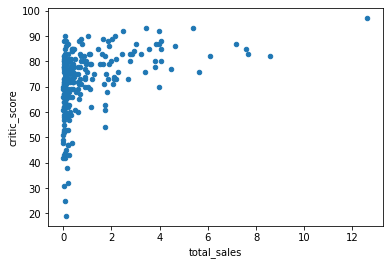

PS4   Корреляция оценок критиков с продажами:  0.41
PS4   Корреляция оценок пользователей с продажами:  -0.03

XOne   Диаграмма рассеяния: оценки критиков vs продажи


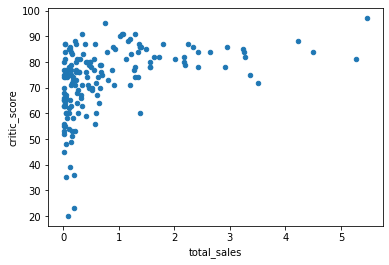

XOne   Корреляция оценок критиков с продажами:  0.42
XOne   Корреляция оценок пользователей с продажами:  -0.07

WiiU   Диаграмма рассеяния: оценки критиков vs продажи


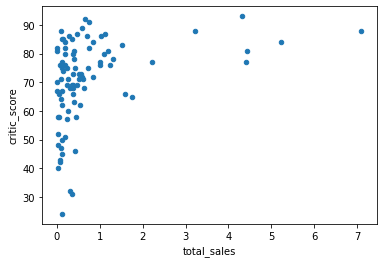

WiiU   Корреляция оценок критиков с продажами:  0.35
WiiU   Корреляция оценок пользователей с продажами:  0.4

PC   Диаграмма рассеяния: оценки критиков vs продажи


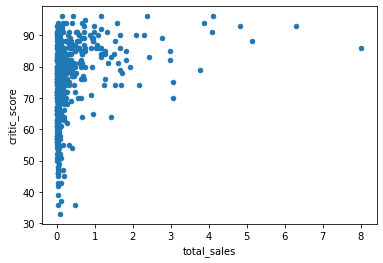

PC   Корреляция оценок критиков с продажами:  0.26
PC   Корреляция оценок пользователей с продажами:  0.01



In [188]:
for p in ['PS4', 'XOne', 'WiiU', 'PC']:
    print(p,'  Диаграмма рассеяния: оценки критиков vs продажи')
    dfp = df.query('platform == @p')
    dfp.plot(x='total_sales', y='critic_score', kind='scatter')
    plt.show()
    print(p,'  Корреляция оценок критиков с продажами: ',dfp['total_sales'].corr(dfp['critic_score']).round(2))
    print(p,'  Корреляция оценок пользователей с продажами: ',dfp['total_sales'].corr(dfp['user_score']).round(2))
    print('')

Чтобы убедиться в том, что полученные значения типичны, найдем коэффициенты корреляции для полного списка платформ и вычислим медианное значение коэффициента.

In [189]:
# создадим таблицу коэффициентов корреляции для всех платформ
columns1 = ['platform', 'critic_score_coef.corr.', 'user_score_coef.corr.'] 
data1 = []
for pl in range(len(df1)):
    pl=df1.loc[pl,'platform']
    dfp = df.query('platform == @pl')
    critic_cc = dfp['total_sales'].corr(dfp['critic_score'])
    user_cc = dfp['total_sales'].corr(dfp['user_score'])
    row1 = [pl,critic_cc,user_cc]
    data1.append(row1)
crltn = pd.DataFrame(data=data1, columns=columns1)

# теперь выведем на экран медианное значение коэффициента корреляции
print('Корреляция оценок критиков с продажами (медианное значение): ',crltn['critic_score_coef.corr.'].median().round(2))
print('Корреляция оценок пользователей с продажами (медианное значение): ',crltn['user_score_coef.corr.'].median().round(2))

Корреляция оценок критиков с продажами (медианное значение):  0.35
Корреляция оценок пользователей с продажами (медианное значение):  0.13


#### Вывод по корреляции между отзывами и продажами

Взаимосвязь между оценками критиков и уровнем продаж присутствует, но слабая (коэффициент Пирсона 0.26-0.0.42 для перспективных платформ, 0.35 - медианное значение для всего списка из 31 платформы).  
Взаимосвязи между оценками пользователей и уровнем продаж в среднем очень низкая. Лишь для одной из 4-х перспективных платформ коэфициент корреляции равен 0.4, а для остальных трех - почти ноль. Медианное значения для всех списка из 31 платформы-  0.13.

### 3.3. Анализ распределения игр по жанрам

In [190]:
# на основе оригинальной таблицы df создадим таблицу df2013, содержащую данные только за актуальный период  
df2013=df[df['year_of_release']>=2013].reset_index(drop=True)
df2013.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


In [191]:
df_genre=df2013.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values('total_sales',ascending=False).reset_index()

In [192]:
df_genre

,genre,total_sales
0,Action,321.87
1,Shooter,232.98
2,Sports,150.65
3,Role-Playing,145.89
4,Misc,62.82
5,Platform,42.63
6,Racing,39.89
7,Fighting,35.31
8,Adventure,23.64
9,Simulation,21.76


#### Вывод анализа распределения игр по жанрам
На первый взгляд, судя по продажам в денежном выражении, динамичные игры, требующие активных действий, являются гораздо более популярными, чем спокойные и интелектуальные. Но не стоит забывать, что производство игр в жанрах Action или Shooter обходится дороже, чем производство Puzzle-игр.

### 4. Портрет пользователя каждого региона

### 4.1. Сравнение предпочтения платформ по регионам

  platform  na_sales     %
0      PS4    108.74  24.8
1     XOne     93.12  21.3
2     X360     81.66  18.7
3      PS3     63.50  14.5
4      3DS     38.20   8.7


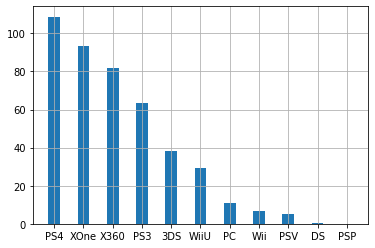


  platform  eu_sales     %
0      PS4    141.09  36.0
1      PS3     67.81  17.3
2     XOne     51.59  13.2
3     X360     42.52  10.8
4      3DS     30.96   7.9


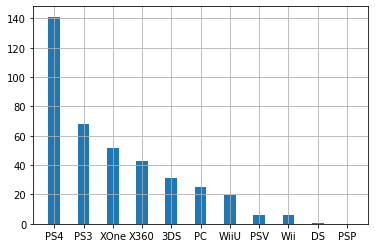


  platform  jp_sales     %
0      3DS     67.81  48.2
1      PS3     23.35  16.6
2      PSV     18.59  13.2
3      PS4     15.96  11.3
4     WiiU     10.88   7.7


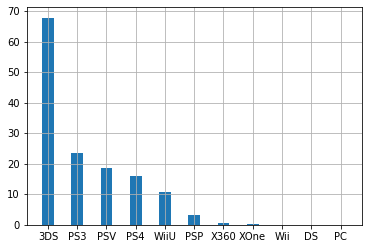

In [193]:
# выведем на экран значения продаж пяти самых популярных платформ каждого региона и их долю в процентах от суммы продаж в регионе
for reg in ['na','eu','jp']:
    val=''.join([reg,'_sales'])
    plat_reg=df2013.pivot_table(index='platform', values=val, aggfunc='sum').sort_values(val,ascending=False).reset_index()
    total=plat_reg[val].sum().round(2)
    plat_reg['%']=(plat_reg[val]/total*100).round(1)
    print(plat_reg.head())
    plt.bar(plat_reg['platform'], plat_reg[val], width=0.4)
    plt.grid()
    plt.show()
    print('')

In [194]:
# проверим, верен ли для Японии вывод о тенденции сижения продаж платформы 3DS, сделанный на основе сумме продаж по всем трем регионам
df2013.pivot_table(index='platform', columns='year_of_release', values='jp_sales', aggfunc='sum').reset_index().query('platform=="3DS"')

year_of_release,platform,2013,2014,2015,2016
0,3DS,23.57,20.69,15.52,8.03


Да, в Японии продажи 3DS тоже постепенно снижаются.

#### Вывод сравнения предпочтения платформ по регионам
В Северной Америке и Европе пользователи в выборе платформ похожи - топ-5 список состоит из одинаковых названий при небольшой разности в очередности. На первом месте - PS4, завершает топ-5 3DS.   
Надо отметить, что в Европе платформа PS4 лидирует с существенным отрывом, более чем в два раза опережая PS3, стоящую на втором месте. В Сев.Америке такого не наблюдается.   
В Японии, в отличии от Сев.Америки и Европы, в список наиболее популярных попали PSV и WiiU, отсутсвуют XOne и X360, а 3DS является абсолютным лидером, более чем в два раза опережая PS3, стоящую на втором месте.

### 4.2. Сравнение предпочтения жанров по регионам

          genre  na_sales     %
0        Action    126.05  28.8
1       Shooter    109.74  25.1
2        Sports     65.27  14.9
3  Role-Playing     46.40  10.6
4          Misc     27.49   6.3


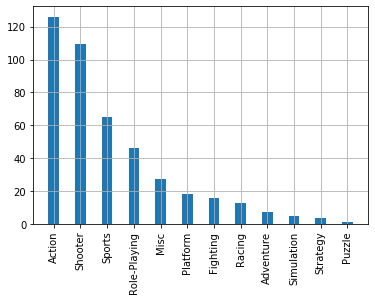


          genre  eu_sales     %
0        Action    118.13  30.1
1       Shooter     87.86  22.4
2        Sports     60.52  15.4
3  Role-Playing     36.97   9.4
4        Racing     20.19   5.1


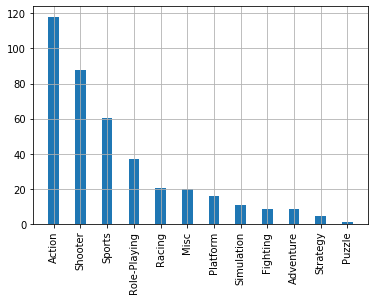


          genre  jp_sales     %
0  Role-Playing     51.04  36.3
1        Action     40.49  28.8
2          Misc      9.20   6.5
3      Fighting      7.65   5.4
4       Shooter      6.61   4.7


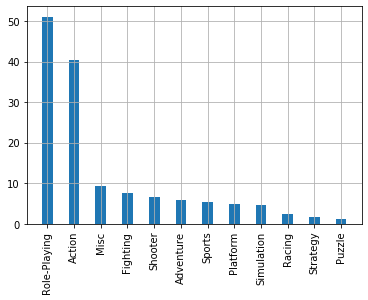

In [195]:
# выведем на экран значения продаж пяти самых популярных жанров каждого региона и их долю в процентах от суммы продаж в регионе
for reg1 in ['na','eu','jp']:
    val1=''.join([reg1,'_sales'])
    genre_reg=df2013.pivot_table(index='genre', values=val1, aggfunc='sum').sort_values(val1,ascending=False).reset_index()
    total1=genre_reg[val1].sum().round(2)
    genre_reg['%']=(genre_reg[val1]/total1*100).round(1)
    print(genre_reg.head())
    plt.bar(genre_reg['genre'], genre_reg[val1], width=0.4)
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()
    print('')

#### Вывод сравнения предпочтения жанров по регионам
В Северной Америке и Европе пользователи в выборе жанров похожи - топ-4 список состоит из одинаковых названий при очень близких долях от общих продаж. На первом месте - Action, потом идет Shooter.    
Выбор жителей Японии очень отличается от Сев.Америки и Европы: Role-Playing на первом месте, Action - на втором.  
Единственная общая черта всех трех регионов - большая доля жанра Action (29-30%) от общих продаж.

### 4.3. Влияние рейтинга ESRB на продажи в отдельном регионе

  rating  na_sales     %
0      M    165.21  47.4
1      E     79.05  22.7
2   E10+     54.24  15.6
3      T     49.79  14.3


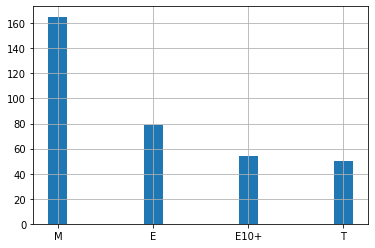


  rating  eu_sales     %
0      M    145.32  46.4
1      E     83.36  26.6
2   E10+     42.69  13.6
3      T     41.95  13.4


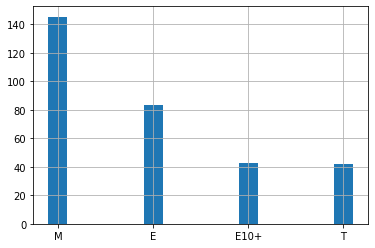


  rating  jp_sales     %
0      T     20.59  36.9
1      E     15.14  27.2
2      M     14.11  25.3
3   E10+      5.89  10.6


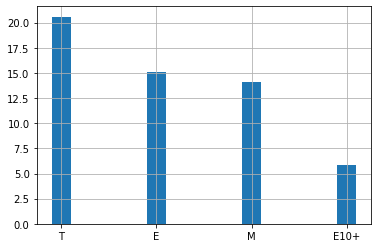

In [196]:
# выведем на экран значения продаж категорий рейтинга ESRB каждого региона и их долю в процентах от суммы продаж в регионе
for reg2 in ['na','eu','jp']:
    val2=''.join([reg2,'_sales'])
    esrb_reg=df2013.pivot_table(index='rating', values=val2, aggfunc='sum').sort_values(val2,ascending=False).reset_index()
    total2=esrb_reg[val2].sum().round(2)
    esrb_reg['%']=(esrb_reg[val2]/total2*100).round(1)
    print(esrb_reg)
    plt.bar(esrb_reg['rating'], esrb_reg[val2], width=0.2)
    plt.grid()
    plt.show()
    print('')

#### Вывод оценки влияния рейтинга ESRB на продажи в отдельном регионе
В Северной Америке и Европе зависимость между рейтингом ESRB и уровнем продаж практически одинаковая. Наиболее популярны игры рейтинга М, которые более чем в два раза опережают игры рейтинга Е, занимающие второе место.  
Выбор жителей Японии очень отличается от Сев.Америки и Европы - на первом месте рейтинг Т без существенного отрыва от второго места.  
Общая черта всех трех регионов - близкие по значению доли игр рейтинга E (23-27%) и Е10+ (11-16%) от общих продаж.

### Общий вывод сравнения пользователей разных регионов

Заметно сходство пользователей из Северной Америки и Европы:они отдают предпочтение платформе PS4, жанрам Action и Shooter, явно чаще выбирают игры рейтинга М.  
Японцы предпочитают платформу 3DS, жанр Role-Playing в Японии заметно популярнее жанра Action, а по рейтингу ESRB - на первом месте категория Т.

### 5. Проверка гипотез

### 5.1. Сравнение средних пользовательских рейтингов платформ XOne и PC

Сформулируем нулевую гипотезу так, чтобы использовать знак равенства. Альтернативная гипотеза формулируется исходя из нулевой.  

Нулевая гипотеза:  
Средний пользовательский рейтинг платформы XOne равен рейтингу платформы PC.  
Альтернативная гипотеза:  
Средний пользовательский рейтинг платформы XOne не равен рейтингу платформы PC.

В качестве критерия для проверки гипотезы будем использовать средний пользовательский рейтинг за актуальный период (2013-2016).

Будем  работать с таблицей df2013.

In [197]:
df2013.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


In [198]:
# сделаем срезы по платформам и сразу удалим строки с отсутствующими значениями пользовательских оценок (это необходимо для
# проведения статистического теста методом scipy.stats.ttest_ind())
df_xone = df2013.query('platform=="XOne"').dropna(subset=['user_score'])
df_pc = df2013.query('platform=="PC"').dropna(subset=['user_score'])

In [199]:
# проверем, какая часть данных осталась после удаления строк с отсутствующими значениями пользовательских оценок
print('XOne: ', 'Осталось %:',round(len(df_xone)/len(df2013.query('platform=="XOne"'))*100), '  Осталось строк:', len(df_xone))
print('РС: ', 'Осталось %:',round(len(df_pc)/len(df2013.query('platform=="PC"'))*100), '  Осталось строк:', len(df_pc))

XOne:  Осталось %: 74   Осталось строк: 182
РС:  Осталось %: 82   Осталось строк: 155


Будем считать потери приемлимыми и оставшееся количество строк достаточным для проведения статистического теста.

In [200]:
# дисперсия пользовательских рейтингов платформ
var_xone = np.var(df_xone['user_score']).round(2)
var_pc = np.var(df_pc['user_score']).round(2)
print('Дисперсия пользовательского рейтинга платформы XOne:', var_xone)
print('Дисперсия пользовательского рейтинга платформы PC:', var_pc)

Дисперсия пользовательского рейтинга платформы XOne: 1.9
Дисперсия пользовательского рейтинга платформы PC: 3.02


Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей (пользовательских рейтингов платформ XOne и PC) по взятым из них выборкам проведем статистический тест - применим метод scipy.stats.ttest_ind() . Методу передадим параметры: df_xone['user_score'] и df_pc['user_score'] - массивы, содержащие выборки. Параметру equal_var передадим значение False, т.к. дисперсии выборок отличаются значительно.

In [201]:
pl_alpha = 0.05 # критический уровень статистической значимости
pl_result = st.ttest_ind(df_xone['user_score'],df_pc['user_score'], equal_var=False) # статистический тест
pl_beta = pl_result.pvalue # p-value - вероятность получить предполагаемый результат при условии, что нулевая гипотеза верна
print('p-значение: ',pl_beta.round(2)) 
if (pl_beta < pl_alpha):
    print("Отвергаем нулевую гипотезу, т.е. средние пользовательские рейтинги платформ XOne и PC не одинаковы. ")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.15
Не получилось отвергнуть нулевую гипотезу


#### Вывод сравнения средних пользовательских рейтингов платформ XOne и PC
Р-значение, равное 0.15, говорит о том, что с вероятностью 15% пользовательские рейтинги платформ XOne и PC могут быть одинаковы.

### 5.2. Сравнение средних пользовательских рейтингов жанров Action и Sports

Сформулируем нулевую гипотезу так, чтобы использовать знак равенства. Альтернативная гипотеза формулируется исходя из нулевой.  

Нулевая гипотеза:  
Средний пользовательский рейтинг жанра Action равен рейтингу жанра Sports.  
Альтернативная гипотеза:  
Средний пользовательский рейтинг жанра Action не равен рейтингу жанра Sports.

В качестве критерия для проверки гипотезы будем использовать средний пользовательский рейтинг за актуальный период (2013-2016).

Будем  работать с таблицей df2013.

In [202]:
df2013.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


In [203]:
# сделаем срезы по платформам и сразу удалим строки с отсутствующими значениями пользовательских оценок (это необходимо для
# проведения статистического теста методом scipy.stats.ttest_ind())
df_action = df2013.query('genre=="Action"').dropna(subset=['user_score'])
df_sports = df2013.query('genre=="Sports"').dropna(subset=['user_score'])

In [204]:
# проверем, какая часть данных осталась после удаления строк с отсутствующими значениями пользовательских оценок
print('Action: ', 'Осталось %:',round(len(df_action)/len(df2013.query('genre=="Action"'))*100), '  Осталось строк:', len(df_action))
print('Sports: ', 'Осталось %:',round(len(df_sports)/len(df2013.query('genre=="Sports"'))*100), '  Осталось строк:', len(df_sports))

Action:  Осталось %: 51   Осталось строк: 389
Sports:  Осталось %: 75   Осталось строк: 160


Будем считать потери приемлимыми и оставшееся количество строк достаточным для проведения статистического теста.

In [205]:
# дисперсия пользовательских рейтингов жанров
var_action = np.var(df_action['user_score']).round(2)
var_sports = np.var(df_sports['user_score']).round(2)
print('Дисперсия пользовательского рейтинга жанра Action:', var_action)
print('Дисперсия пользовательского рейтинга жанра Sports:', var_sports)

Дисперсия пользовательского рейтинга жанра Action: 1.76
Дисперсия пользовательского рейтинга жанра Sports: 3.16


Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей (пользовательских рейтингов жанров Action и Sports) по взятым из них выборкам проведем статистический тест - применим метод scipy.stats.ttest_ind() . Методу передадим параметры: df_action['user_score'] и df_sports['user_score'] - массивы, содержащие выборки. Параметру equal_var передадим значение False, т.к. дисперсии выборок отличаются значительно.

In [206]:
ge_alpha = 0.05 # критический уровень статистической значимости
ge_result = st.ttest_ind(df_action['user_score'],df_sports['user_score'], equal_var=False) # статистический тест
ge_beta = ge_result.pvalue # p-value - вероятность получить предполагаемый результат при условии, что нулевая гипотеза верна
print('p-значение: ',ge_beta.round(2)) 
if (ge_beta < ge_alpha):
    print("Отвергаем нулевую гипотезу, т.е. средние пользовательские рейтинги жанров Action и Sports не одинаковы. ")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0
Отвергаем нулевую гипотезу, т.е. средние пользовательские рейтинги жанров Action и Sports не одинаковы. 


#### Вывод сравнения средних пользовательских рейтингов жанров Action и Sports
Р-значение, практически равное 0, говорит о том, что пользовательские рейтинги жанров Action и Sports могут быть одинаковы c практически нулевой вероятностью.

### 6. Общий вывод

Платформа востребована (существует) в среднем 7 лет. В качестве актуального периода приняли половину этого срока - с 2013 по 2016 год.  

Из платформ с наибольшими суммарными продажами (которые превышают среднее значение):  
-растущие платформы: PS4 (лидер) и XOne,  
-продажи падают: 3DS, PS3, X360,  
-стабильный уровень продаж, изменения маловероятны: WiiU, РС.  
Соответственно, потенциально прибыльными платформами являются PS4, XOne, WiiU, PC.

Взаимосвязь между оценками критиков и уровнем продаж присутствует, но слабая (коэффициент Пирсона 0.26-0.0.42 для перспективных платформ, 0.35 - медианное значение для всего списка из 31 платформы).  
Взаимосвязи между оценками пользователей и уровнем продаж в среднем очень низкая. Лишь для одной из 4-х перспективных платформ коэфициент корреляции равен 0.4, а для остальных трех - почти ноль. Медианное значения для всех списка из 31 платформы-  0.13.  

Динамичные игры, требующие активных действий, являются гораздо более популярными, чем спокойные и интелектуальные.  

Заметно сходство пользователей из Северной Америки и Европы:они отдают предпочтение платформе PS4, жанрам Action и Shooter, явно чаще выбирают игры рейтинга М.  
Японцы пока еще предпочитают платформу 3DS, жанр Role-Playing в Японии заметно популярнее жанра Action, а по рейтингу ESRB - на первом месте категория Т.

С вероятностью 15% пользовательские рейтинги платформ XOne и PC могут быть одинаковы.  
Пользовательские рейтинги жанров Action и Sports могут быть одинаковы c практически нулевой вероятностью.